In [2]:
import glob
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import sklearn.preprocessing as preproc
import sklearn.linear_model as lm
import sklearn.pipeline
from scipy.optimize import least_squares
from IPython.display import Image
import xlrd
%matplotlib inline

In [59]:
path = 'data/CEDA/'
all_files = glob.glob(os.path.join(path, "ceda*.xls*"))
df_list = []
for infile in all_files[0:]:
    print('\n'+infile)
    nom_cols = pd.Index(['MeasID', 'YEAR', 'CO', 'JUR', 'CNTYNAME', 'DATE', 'PLACE', 'CSD',
       'MEASTYPE', 'LTR', 'BALQUEST', 'Orig_TYPE', 'RECTYPE', 'RECTYPENAME',
       'Orig_TOPIC', 'RECTOPIC', 'RECTOPNAME', 'YES', 'NO', 'TOTAL', 'PERCENT',
       'REQ', 'OUTCOME', 'PASSFAIL', 'Multi_CO', 'Multi_MeasID', 'YES_sum',
       'NO_sum', 'Total_sum', 'Percent_sum', 'Outcome_sum', 'passfail_sum',
       'typerec', 'topicrec', 'OTH'],dtype='object')
    xls = pd.ExcelFile(infile)
    df0 = pd.read_excel(xls, 0)
    df1 = pd.read_excel(xls, 1)
    if 'MeasureID' in df0.columns.values or 'MeasID' in df0.columns.values:
        df_this = df0
    else:
        df_this = df1

    if 'MeasID_First' in df_this.columns.values:
        del df_this['MeasID_First']
        
    if 'OTH' not in df_this.columns.values:
        df_this['OTH'] = np.nan
        
    if 'Orig_TYPE' not in df_this.columns.values:
        df_this['Orig_TYPE'] = np.nan
        
    if 'Orig_TOPIC' not in df_this.columns.values:
        df_this['Orig_TOPIC'] = np.nan
    
    cols = df_this.columns.values
    for idx,col in enumerate(cols):
        if col not in nom_cols.values:
            if col in ['TOPICREC','topcrec']:
                cols[idx] = 'topicrec'
            elif col == 'MeasureID':
                cols[idx] = 'MeasID'
            elif col == 'TYPEREC':
                cols[idx] = 'typerec'
            elif col == 'Passfail_sum':
                cols[idx] = 'passfail_sum'
            elif col == 'RECTOPICNAME':
                cols[idx] = 'RECTOPNAME'
            elif col == 'CO#':
                cols[idx] = 'CO'
            else:
                print(col)
    df_this.columns = cols
        
    for nom_col in nom_cols.values:
        if nom_col not in df_this.columns.values:
            print(nom_col)

    if not df_this.columns.equals(nom_cols):
        print(df_this.columns.difference(nom_cols))
        print(nom_cols.difference(df_this.columns))

    df_this.index = df_this['MeasID']
    del df_this['MeasID']
    df_list.append(df_this)


data/CEDA/ceda-2016-data.xlsx
Index([], dtype='object')
Index([], dtype='object')

data/CEDA/ceda1996data.xls

data/CEDA/ceda1997data.xls

data/CEDA/ceda1998data.xls

data/CEDA/ceda1999data.xls

data/CEDA/ceda2000data.xls

data/CEDA/ceda2001data.xls

data/CEDA/ceda2002data.xls

data/CEDA/ceda2003data.xls

data/CEDA/ceda2004data.xls

data/CEDA/ceda2005data.xls

data/CEDA/ceda2006data.xls

data/CEDA/ceda2007data.xls

data/CEDA/ceda2008data.xls

data/CEDA/ceda2009data.xls

data/CEDA/ceda2010data.xls

data/CEDA/ceda2011data.xlsx

data/CEDA/ceda2012data.xlsx

data/CEDA/ceda2013data.xlsx
Index([], dtype='object')
Index([], dtype='object')

data/CEDA/ceda2015data.xlsx
Index([], dtype='object')
Index([], dtype='object')

data/CEDA/cedadata2014.xlsx
Index([], dtype='object')
Index([], dtype='object')


In [61]:
df = pd.concat(df_list)

In [69]:
df['CNTYNAME'] = df['CNTYNAME'].map(lambda x: x.upper())

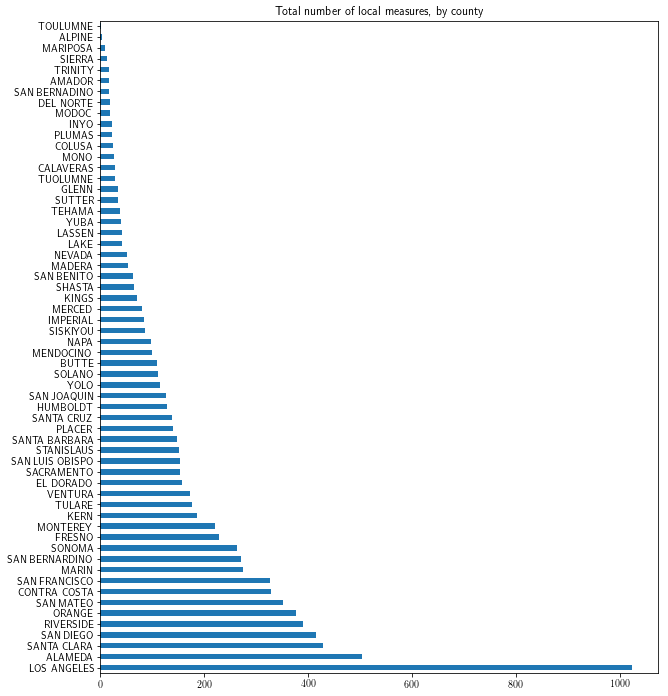

In [76]:
num_measures_tot = df['CNTYNAME'].value_counts()
plt.figure(figsize=(10, 12))
num_measures_tot.plot(kind='barh')
plt.title('Total number of local measures, by county')

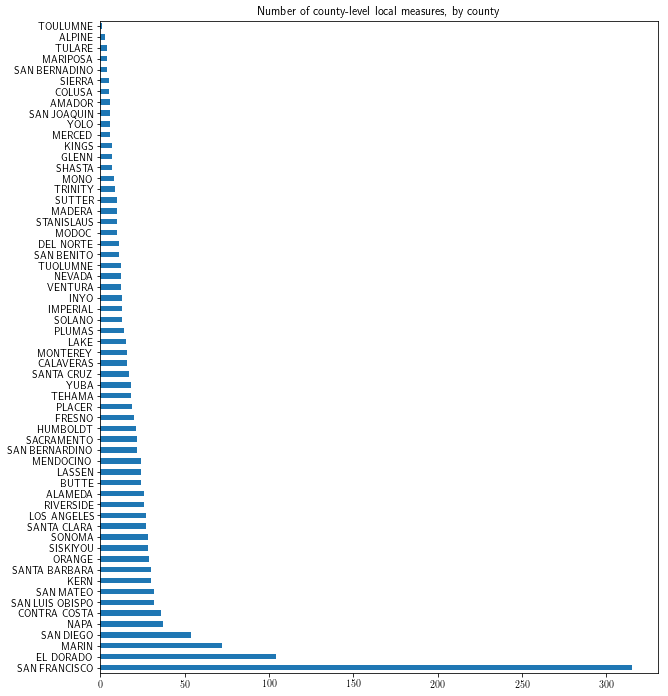

In [75]:
num_measures_county = df.query('JUR == 1')['CNTYNAME'].value_counts()
plt.figure(figsize=(10, 12))
num_measures_county.plot(kind='barh')
plt.title('Number of county-level local measures, by county')

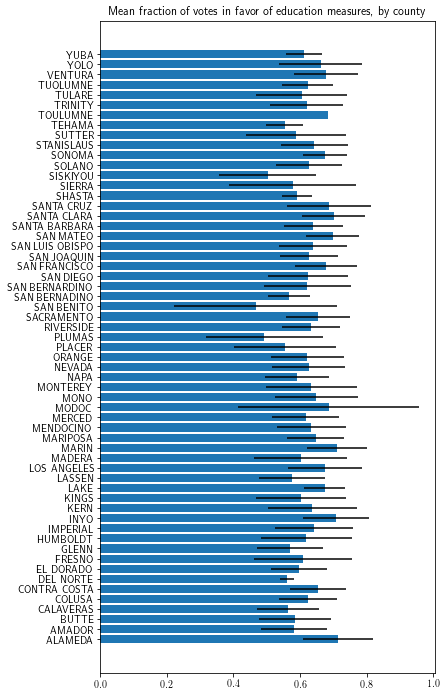

In [112]:
df_ed = df.query('RECTOPIC < 20')
num_ed_by_cnty = df_ed['CNTYNAME'].value_counts().sort_index()
mean_ed_percent_by_cnty = df_ed.groupby('CNTYNAME')['PERCENT'].mean()
std_ed_percent_by_cnty = df_ed.groupby('CNTYNAME')['PERCENT'].std()
ind = np.arange(len(mean_ed_percent_by_cnty))
plt.figure(figsize=(6, 12))
plt.barh(ind,mean_ed_percent_by_cnty.values,xerr=std_ed_percent_by_cnty.values)
plt.yticks(ind,mean_ed_percent_by_cnty.index.values,rotation=0);
plt.title('Mean fraction of votes in favor of education measures, by county')

In [113]:
def load_registration_data(path = 'data/SOS/processed/voter-registration.csv'):
    df = pd.read_csv(path,header=[0,1],index_col=[0,1])
    dtIdx = pd.DatetimeIndex(df.columns.get_level_values(0))
    col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.columns.get_level_values(1)])
    df.columns = col_mIdx
    df.sort_index(inplace=True,axis=1,level=[0,1])
    df.sort_index(axis=1,level=[0,1],inplace=True)
    df.sort_index(axis=0,level=[0,1],inplace=True)
    return df
df_reg = load_registration_data()

In [ ]:
idx = pd.IndexSlice
df_reg[idx[:,'Count']]